# Лабораторная работа №1

(Квази) линейные методы классификации.

## 0\. Импортировать необходимые модули:

In [2]:
%matplotlib inline

from itertools import combinations
from typing import Protocol, Any

import numpy as np

from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.ticker import FormatStrFormatter
from pandas import DataFrame, Series
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import Bunch

### 1\.1\. Загрузить таблицу Iris из sklearn.datasets в виде **pandas.DataFrame**.

In [3]:
iris_bunch: Bunch = datasets.load_iris(as_frame=True)
iris_dataframe: DataFrame = iris_bunch["frame"]

iris_dataframe

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


### 1\.2\. Вычислить корреляции между признаками на всей таблице.

In [4]:
def via_numpy_scaler(d: DataFrame) -> np.ndarray:
    return np.corrcoef(StandardScaler().fit_transform(d.loc[::, "sepal length (cm)": "petal width (cm)"]).T)


def via_dataframe_interface(d: DataFrame) -> DataFrame:
    return d.loc[::, "sepal length (cm)": "petal width (cm)"].corr()


via_numpy_scaler(iris_dataframe)

array([[ 1.        , -0.11756978,  0.87175378,  0.81794113],
       [-0.11756978,  1.        , -0.4284401 , -0.36612593],
       [ 0.87175378, -0.4284401 ,  1.        ,  0.96286543],
       [ 0.81794113, -0.36612593,  0.96286543,  1.        ]])

### 1\.3\. Вычислить корреляции между признаками отдельно по классам.

In [5]:
for iris_class in range(0, 3):
    display(f'Class: {iris_bunch["target_names"][iris_class]}')
    display(via_dataframe_interface(iris_dataframe.loc[iris_dataframe["target"] == iris_class]))

'Class: setosa'

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,0.742547,0.267176,0.278098
sepal width (cm),0.742547,1.000000,0.177700,0.232752
petal length (cm),0.267176,0.177700,1.000000,0.331630
petal width (cm),0.278098,0.232752,0.331630,1.000000


'Class: versicolor'

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,0.525911,0.754049,0.546461
sepal width (cm),0.525911,1.000000,0.560522,0.663999
petal length (cm),0.754049,0.560522,1.000000,0.786668
petal width (cm),0.546461,0.663999,0.786668,1.000000


'Class: virginica'

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,0.457228,0.864225,0.281108
sepal width (cm),0.457228,1.000000,0.401045,0.537728
petal length (cm),0.864225,0.401045,1.000000,0.322108
petal width (cm),0.281108,0.537728,0.322108,1.000000


### 1\.4\. Визуализировать распределения классов на всех парах переменных.

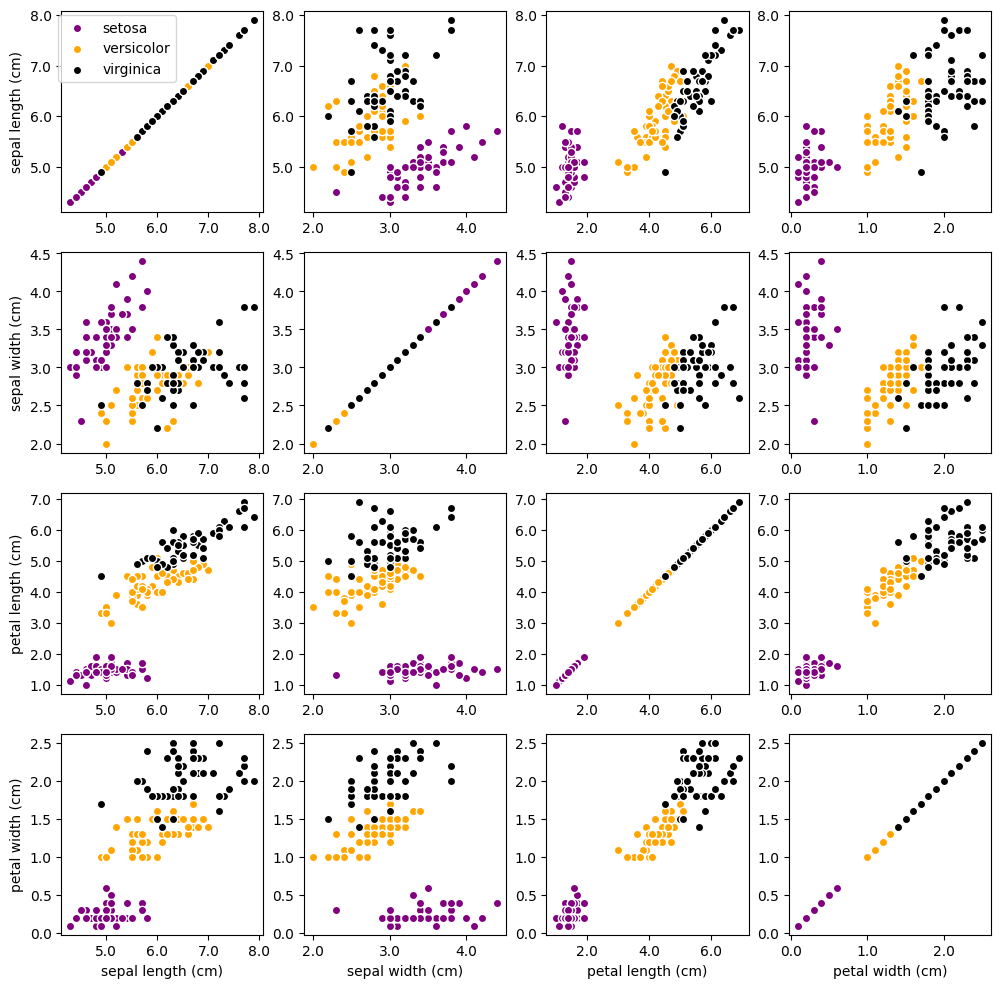

In [6]:
figure = Figure(figsize=(12, 12))
subplots: list[list[Axes]] = [list(row) for row in figure.subplots(4, 4)]
axes: Axes

colors = ("purple", "orange", "black")
formatter = FormatStrFormatter("%.1f")

for target, grouped in iris_dataframe.groupby("target"):
    for y_feature, row in zip(iris_bunch["feature_names"], subplots):
        axes, *_ = row; axes.set_ylabel(y_feature)
        for x_feature, axes in zip(iris_bunch["feature_names"], row):
            axes.scatter([grouped[x_feature]], [grouped[y_feature]], c=colors[target], label=iris_bunch["target_names"][target], edgecolors="white")
            axes.xaxis.set_major_formatter(formatter)
            axes.yaxis.set_major_formatter(formatter)

for x_feature, axes in zip(iris_bunch["feature_names"], row):  # noqa
    axes.set_xlabel(x_feature)

figure.legend(iris_bunch["target_names"], bbox_to_anchor=(0.226, 0.882))
display(figure)

### 2\.1\. Выбрать две переменные.

In [7]:
cut_dataframe: DataFrame = iris_dataframe[["sepal width (cm)", "petal width (cm)", "target"]][iris_dataframe["target"] != 0]

X = cut_dataframe.iloc[::, :2].values
y = cut_dataframe["target"].values

### 2\.2\. Построить решения заданными методами.

In [8]:
class FitAndPredictMixin(Protocol):
    def fit(self, X: Any, y: Any, sample_weight: Any = None) -> object:  # noqa
        ...

    def predict(self, X: Any) -> Any:  # noqa
        ...


classifiers: dict[str, FitAndPredictMixin] = {
    "SVM, линейное ядро": SVC(kernel="linear", C=1),
    "Линейный дискриминант": LinearDiscriminantAnalysis(store_covariance=True),
    "Логистическая регрессия": LogisticRegression(random_state=0),
    "SVM, квадратичное ядро": SVC(kernel="poly", degree=2, gamma="auto", C=1),
    "Квадратичный дискриминант": QuadraticDiscriminantAnalysis(store_covariance=True),
    "Гауссовский наивный байесовский": GaussianNB(),
}

for clf in classifiers.values():
    clf.fit(X, y)

### 2\.3\. Отобразить полученные решения.

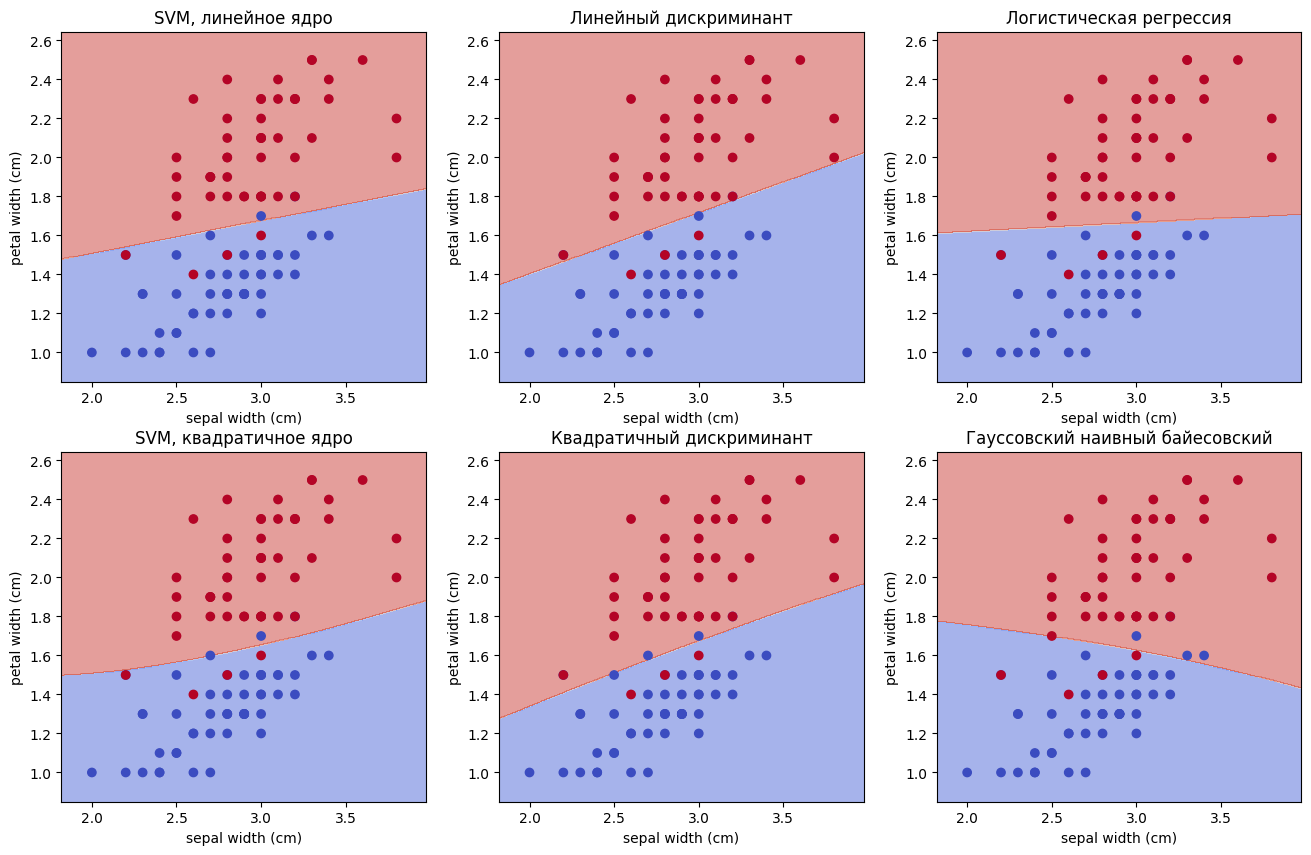

In [9]:
def get_points(s: Series, padding: float = 0.1, step: float = 0.005) -> np.ndarray[float]:
    s_max, s_min = s.max(), s.min()
    delta = s_max - s_min
    pad = delta * padding

    return np.arange(s_min - pad, s_max + pad, step)

xv: np.ndarray[float]
yv: np.ndarray[float]

xv, yv = np.meshgrid(
    get_points(cut_dataframe["sepal width (cm)"]),
    get_points(cut_dataframe["petal width (cm)"]),
)

figure = Figure(figsize=(16, 10))
subplots: np.ndarray[Axes] = figure.subplots(2, 3).flatten()

for axes, (name, clf) in zip(subplots, classifiers.items()):
    Z: np.ndarray[int] = clf.predict(np.c_[xv.ravel(), yv.ravel()]).reshape(xv.shape)

    axes.contourf(xv, yv, Z, cmap="coolwarm", alpha=0.5)
    axes.scatter(cut_dataframe["sepal width (cm)"], cut_dataframe["petal width (cm)"], c=y, cmap="coolwarm")

    axes.set_title(name)
    axes.set_xlabel("sepal width (cm)")
    axes.set_ylabel("petal width (cm)")

display(figure)

### 3\.1\. Построить линейный дискриминант на всех переменных.

In [10]:
lda_clf = LinearDiscriminantAnalysis()

tc_dataframe = iris_dataframe.loc[iris_dataframe["target"] != 0].copy()
X = tc_dataframe.iloc[::, :-1]
y = tc_dataframe.iloc[::, -1]

lda_clf.fit(X, y)

tc_dataframe["prediction"] = lda_clf.predict(X)
tc_dataframe.loc[tc_dataframe["target"] != tc_dataframe["prediction"]]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,prediction
70,5.9,3.2,4.8,1.8,1,2
83,6.0,2.7,5.1,1.6,1,2
133,6.3,2.8,5.1,1.5,2,1


### 3\.2\. Визуализировать ответы во всех двумерных подпространствах.

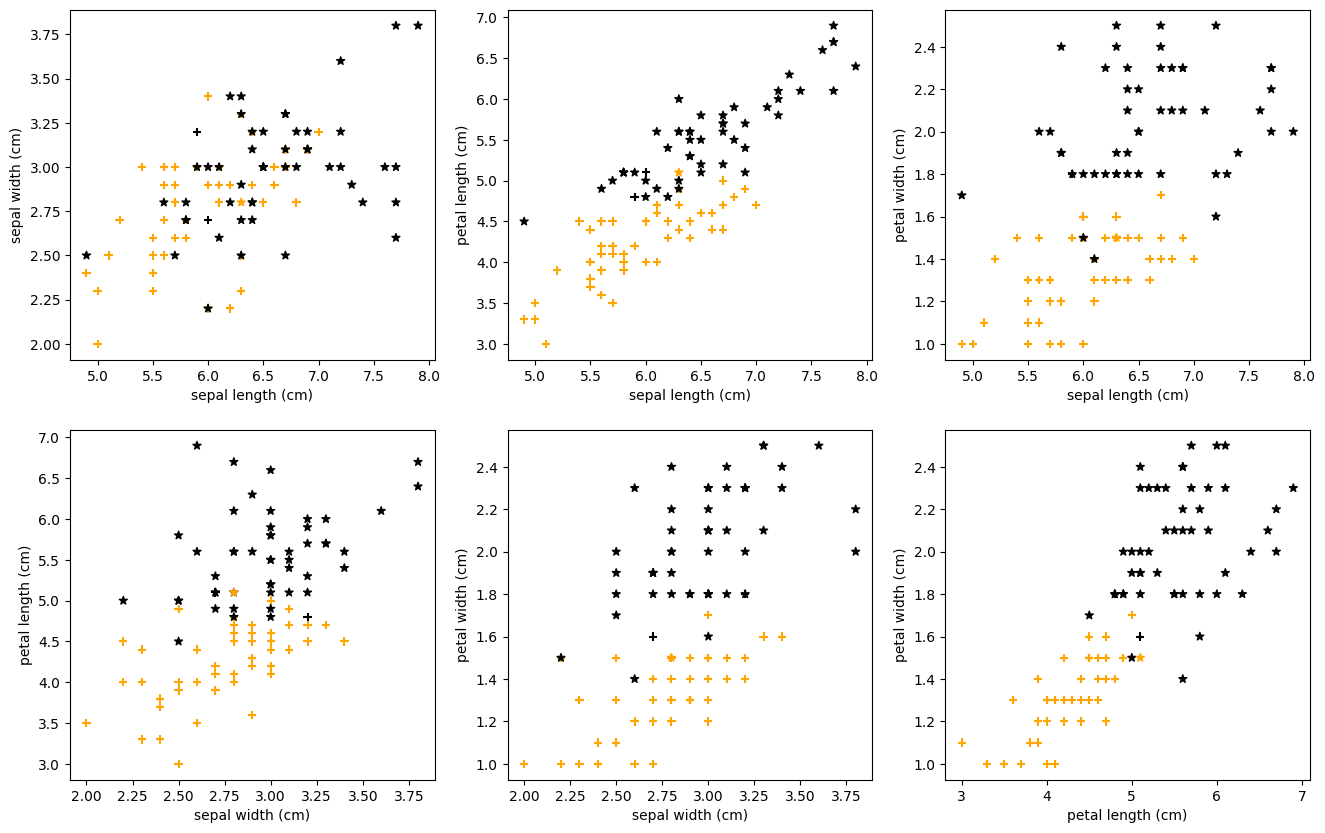

In [11]:
sub_dimensions = combinations(iris_bunch["feature_names"], 2)

figure = Figure(figsize=(16, 10))
subplots: np.ndarray[Axes] = figure.subplots(2, 3).flatten()
mapping = [colors[p] for p in tc_dataframe["prediction"]]

versicolor_dataframe = tc_dataframe[tc_dataframe["target"] == 1]
virginica_dataframe = tc_dataframe[tc_dataframe["target"] == 2]

versicolor_mapping = [colors[p] for p in versicolor_dataframe["prediction"]]
virginica_mapping = [colors[p] for p in virginica_dataframe["prediction"]]

for (x, y), axes in zip(sub_dimensions, subplots):
    axes.scatter(versicolor_dataframe[x], versicolor_dataframe[y], c=versicolor_mapping, marker="+")
    axes.scatter(virginica_dataframe[x], virginica_dataframe[y], c=virginica_mapping, marker="*")
    axes.set_xlabel(x)
    axes.set_ylabel(y)

display(figure)

### 4\.1\. Самостоятельно вычислить квадратичную разделяющую функцию.

In [12]:
class HandcraftedQuadraticDiscriminantAnalysis(ClassifierMixin):
    CLASSES = (1, 2)
    
    @staticmethod
    def delta(x: Any, mu: Any, inv_cov: Any, log_det_cov: Any, pi: Any) -> Any:  # noqa
        return (-0.5) * (x - mu).T @ inv_cov @ (x - mu) - log_det_cov + pi
    
    def fit(self, X: Any, y: Any) -> Any:  # noqa
        self.kwargs = {  # noqa
            t: {
                "mu": X[y == t].mean(axis=0),
                "inv_cov": np.linalg.inv(cov := np.cov(X[y == t], rowvar=False)),
                "log_det_cov": 0.5 * np.log(np.linalg.det(cov)),
                "pi": np.log(len(X[y == t]) / len(y))
            }
            for t in self.CLASSES
        }

    def predict(self, X: Any) -> Any:  # noqa
        prediction = []
        
        for x in X:  # noqa
            delta = {t: self.delta(x, **kwargs) for t, kwargs in self.kwargs.items()}
            prediction.append(max(delta, key=lambda k: delta[k]))

        return np.array(prediction)

### 4\.2\. Визуализировать полученное решение и сравнить с reference implementation.

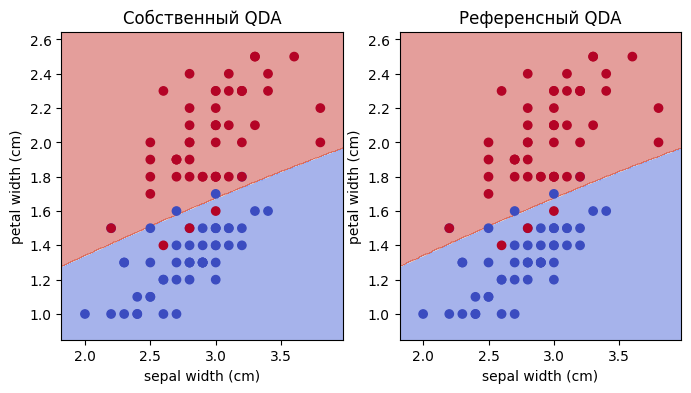

In [13]:
classifiers: dict[str, FitAndPredictMixin] = {
    "Собственный QDA": HandcraftedQuadraticDiscriminantAnalysis(),
    "Референcный QDA": QuadraticDiscriminantAnalysis(store_covariance=True),
}

X = cut_dataframe.iloc[::, :2].values
y = cut_dataframe["target"].values

for clf in classifiers.values():
    clf.fit(X, y)

xv, yv = np.meshgrid(
    get_points(cut_dataframe["sepal width (cm)"]),
    get_points(cut_dataframe["petal width (cm)"]),
)

figure = Figure(figsize=(8, 4))
subplots: np.ndarray[Axes] = figure.subplots(1, 2).flatten()

for axes, (name, clf) in zip(subplots, classifiers.items()):
    Z: np.ndarray[int] = clf.predict(np.c_[xv.ravel(), yv.ravel()]).reshape(xv.shape)

    axes.contourf(xv, yv, Z, cmap="coolwarm", alpha=0.5)
    axes.scatter(cut_dataframe["sepal width (cm)"], cut_dataframe["petal width (cm)"], c=y, cmap="coolwarm")

    axes.set_title(name)
    axes.set_xlabel("sepal width (cm)")
    axes.set_ylabel("petal width (cm)")

display(figure)